Task 4.1 - Convolutional Neural Networks

This is the last assignment on NumPy, you made it to this point! Just one final sprint, and then it’s all PyTorch.

In this assignment, you will implement your own convolutional neural network.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer, ConvolutionalLayer, MaxPoolingLayer, Flattener
from model import ConvNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Loading Data

Got it! Keeping the dimensions as (num_samples,32,32,3)
(num_samples,32,32,3) allows you to work directly with the image data in its original format. If you have any specific operations or transformations in mind for your convolutional layer or any other tasks, feel free to share!

In [ ]:
def prepare_for_neural_network(train_X, test_X):    
    train_X = train_X.astype(np.float32) / 255.0
    test_X = test_X.astype(np.float32) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_X, axis = 0)
    train_X -= mean_image
    test_X -= mean_image
    
    return train_X, test_X
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Let's Implement New Layers!
First, the main new layer - the convolutional layer. Initially, we will implement it for only one channel and then for multiple channels.

The convolutional layer performs the convolution operation with weights for each channel and then sums the results. It might help to review Lecture  or carefully read http://cs231n.github.io/convolutional-networks/.

One approach to implementing a convolutional layer is based on the fact that for a specific "pixel" of the output, applying the convolutional layer is equivalent to a regular fully connected layer.
Let’s consider one such "pixel":
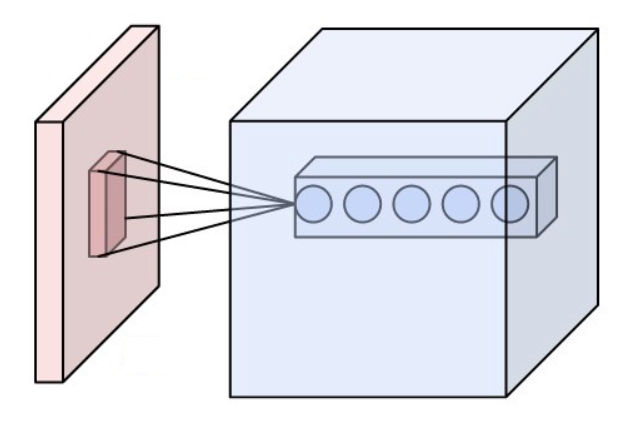

It receives as input   
a region of input I of size `(batch_size, filter_size, filter_size, input_channels)`,  
applies to it weights W of size `(filter_size, filter_size, input_channels, output_channels`
and outputs `(batch_size, output_channels)`. 

Если:  
- the input is transformed into I' of size`(batch_size, filter_size*filter_size*input_channels)`,  
- the weights into W' of size `(filter_size*filter_size*input_channels, output_channels)`,  
then the output for the "pixel" will be equivalent to a fully connected layer with input 
I' and weights W'.

Now we just need to execute it in a loop for each pixel. :)

In [ ]:
# TODO: Implement ConvolutionaLayer that supports only 1 output and input channel

# Note: now you're working with images, so X is 4-dimensional tensor of
# (batch_size, height, width, channels)

X = np.array([
              [
               [[1.0], [2.0]],
               [[0.0], [-1.0]]
              ]
              ,
              [
               [[0.0], [1.0]],
               [[-2.0], [-1.0]]
              ]
             ])

# Batch of 2 images of dimensions 2x2 with a single channel
print("Shape of X:",X.shape)

layer = ConvolutionalLayer(in_channels=1, out_channels=1, filter_size=2, padding=0)
print("Shape of W", layer.W.value.shape)
layer.W.value = np.zeros_like(layer.W.value)
layer.W.value[0, 0, 0, 0] = 1.0
layer.B.value = np.ones_like(layer.B.value)
result = layer.forward(X)

assert result.shape == (2, 1, 1, 1)
assert np.all(result == X[:, :1, :1, :1] +1), "result: %s, X: %s" % (result, X[:, :1, :1, :1])


# Now let's implement multiple output channels
layer = ConvolutionalLayer(in_channels=1, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)


# And now multple input channels!
X = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])

print("Shape of X:", X.shape)
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
assert result.shape == (2, 1, 1, 2)

## Now Let's Implement the Backward Pass
This might be the most challenging part of the course. It will get better from here.

Since the operation of the convolutional layer is equivalent to a fully connected layer for each "pixel" of the output, the overall backward pass is equivalent to the backward pass of each of these "layers."
The gradients from each of these "layers" at each pixel need to be summed into the corresponding pixels of the gradient with respect to the input, while the gradients of the weights should be summed together.

In [ ]:
# First test - check the shape is right
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
result = layer.forward(X)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape

# Actually test the backward pass
# As usual, you'll need to copy gradient check code from the previous assignment
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_gradient(layer, X)

layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'W')
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=2, padding=0)
assert check_layer_param_gradient(layer, X, 'B')

We just need to implement zero padding.
It's sufficient to pad the input tensor with zeros on the sides. Don't forget to take this into account during the backward pass!

In [ ]:
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
result = layer.forward(X)
# Note this kind of layer produces the same dimensions as input
assert result.shape == X.shape,"Result shape: %s - Expected shape %s" % (result.shape, X.shape)
d_input = layer.backward(np.ones_like(result))
assert d_input.shape == X.shape
layer = ConvolutionalLayer(in_channels=2, out_channels=2, filter_size=3, padding=1)
assert check_layer_gradient(layer, X)

## After the next layer, everything will be easy - Max Pooling
Max Pooling is a layer that implements the maximum operation for each channel separately in a neighborhood of pool_size "pixels."

![image](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

And let's remind ourselves what stride is.
Stride is how many "pixels" the window shifts at each step.

In practice, for max pooling, the stride value is often equal to the pool size.

In [ ]:
pool = MaxPoolingLayer(2, 2)
result = pool.forward(X)
assert result.shape == (2, 1, 1, 2)

assert check_layer_gradient(pool, X)

And finally, a layer that transforms four-dimensional tensors into two-dimensional ones.

This layer will be needed to transition from convolutional layers to fully connected layers at the end of the network

In [ ]:
flattener = Flattener()
result = flattener.forward(X)
assert result.shape == (2,8)

assert check_layer_gradient(flattener, X)

# Now that we have all the building blocks, let's create the model.

In [ ]:
# TODO: In model.py, implement missed functions function for ConvNet model

# No need to use L2 regularization
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

In [ ]:
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:16], train_y[:16], val_X[:16], val_y[:16])
trainer = Trainer(model, dataset, SGD(), batch_size=16, learning_rate=1e-4)

loss_history, train_history, val_history = trainer.fit()

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

## Final Exercise
As a final exercise, we will achieve 100% accuracy on the training dataset with a small dataset.
Convolutional networks require a lot of computations and careful, efficient implementation, so we will train the actual models using PyTorch in the next assignment.



## So, let's overfit a small dataset.


In [ ]:
data_size = 128
model = ConvNet(input_shape=(32,32,3), n_output_classes=10, conv1_channels=2, conv2_channels=2)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach 1.0 training accuracy in 50 epochs or less
# Hint: If you have hard time finding the right parameters manually, try grid search or random search!
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-5, num_epochs=50, batch_size=64)

loss_history, train_history, val_history = trainer.fit()

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

The further exercises will be in PyTorch, so open the next notebook! ( I will upload it on 23 October)
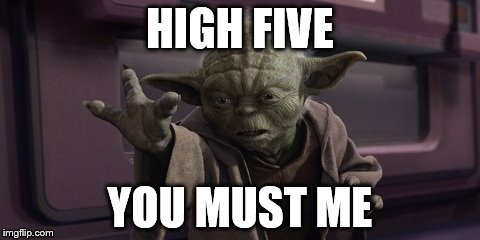